# Generate a ML estimated agb map with  L and PBand

In this exercise, we use machine learning for generating an estimated map of above ground biomass over the Lope National Park, Gabon, using data from the joint NASA-ESA AfriSAR campaign. Specifically, we build the training set with NASA LBand and ESA PBand radar backscatters, by using field data as ground truth. The algorithm involved is the scikit-learn implemetation of Random Forest, and we tuned the hyperparameters to optimize the generalization of the system on unknown data. Furthermore, this notebook has an analysis of the input data, as well as a detailed ranking of feature importance for the trained model.

_time < 10s_

_Input: LBand and PBand raster 40m from N2, LBand and PBand vectors from N3, AGB vector from N1_

## 1. Import modules

In [1]:
import plant
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os import path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from joblib import dump

from IPython.display import Image
%matplotlib inline

## 2. Global variables

In [2]:
from config import *

In [3]:
training_LHH = plant.read_image(training_LHH_file).image
training_LHV = plant.read_image(training_LHV_file).image
training_LVV = plant.read_image(training_LVV_file).image
training_PHV = plant.read_image(training_PHV_file).image

training_agb = plant.read_image(training_agb_file).image

opening: /home/croce/ml/dat/lband/rtc/output/n4/LHH_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/n4/LHV_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/n4/LVV_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/pband/output/n4/PHV_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/field/output/agb_vect.tiff (GDAL: GTiff) 


In [4]:
training_df = pd.DataFrame({'LHH': training_LHH.flatten(), 
                            'LHV': training_LHV.flatten(),
                            'LVV': training_LVV.flatten(),
                            'PHV': training_PHV.flatten(),
                            'agb': training_agb.flatten()
                           })

## 3. Analyze the training set and remove NaN and 0 values

We experienced better results by converting the radar backascatters in dB. We therefore decided to filter out all the NaN and the 0 values from the training set.

In [5]:
print('Training Set:')
print(training_df.shape)
training_df.head()
print('')
print('Number of NaN values:')
print(np.isnan(training_df).sum())
print('')
print('Number of 0 values:')
print((training_df == 0).sum())

Training Set:
(192, 5)

Number of NaN values:
LHH    24
LHV    24
LVV    24
PHV    40
agb    31
dtype: int64

Number of 0 values:
LHH    0
LHV    0
LVV    0
PHV    2
agb    0
dtype: int64


In [6]:
training_df.drop(training_df.loc[training_df['PHV']==0].index, inplace=True)

In [7]:
training_df.dropna(inplace=True)
training_df['LHV'] = 10*np.log10(training_df['LHV'])
training_df['LHH'] = 10*np.log10(training_df['LHH'])
training_df['LVV'] = 10*np.log10(training_df['LVV'])
training_df['PHV'] = 10*np.log10(training_df['PHV'])
training_df.describe()

LHH         LHV         LVV         PHV         agb
count  143.000000  143.000000  143.000000  143.000000  143.000000
mean    -8.741404  -15.206789   -9.497608  -16.684679  186.964594
std      3.286808    5.051626    3.160932    5.762064  151.468725
min    -17.212464  -26.989700  -16.197888  -30.000000    0.018000
25%    -10.783836  -18.860566  -12.676062  -20.457575    5.090000
50%     -7.212464  -12.291480   -7.904850  -13.872161  221.785000
75%     -6.364043  -11.674911   -7.270003  -12.596373  314.808500
max     -5.228787  -10.604807   -6.003263   -9.871628  443.842000

In [8]:
X = training_df[[col for col in training_df.columns if col not in ['agb']]]
y = training_df['agb']

## 4. Train and evaluate the Random Forest Regressor

The Random Forest hyperparameters have been set to optimize the quality of the prediction of the model on unknown data.

In [9]:
ml_model = RandomForestRegressor(n_estimators=100,
                                 max_features='sqrt',
                                 min_samples_leaf=5,
                                 criterion='mae',
                                 bootstrap=True,
                                 oob_score=True,
                                 random_state=0)

In [10]:
scoring = {'neg_mean_absolute_error': 'neg_mean_absolute_error'}
scores = cross_validate(ml_model, X, y, 
                        scoring=scoring, 
                        cv=10, 
                        return_train_score=True,
                        n_jobs=-1)

In [11]:
print('Negative Mean Absolute Error:')
print('TRAIN:', scores['train_neg_mean_absolute_error'].mean())
print('TEST:', scores['test_neg_mean_absolute_error'].mean())

Negative Mean Absolute Error:
TRAIN: -32.94537166142805
TEST: -46.50834304047619


In [12]:
trained_model = ml_model.fit(X, y)
print(trained_model)
print()
print('Out-of-bag score (R^2):', trained_model.oob_score_)
_ = dump(trained_model, model_file_lp) 

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=0, verbose=0,
                      warm_start=False)

Out-of-bag score (R^2): 0.782567146066418


This is one the 100 trees that consitutes the Random Forest model. As we can see, the tree tries to minimize the mean absolute error of the samples in each leaf node. The randomly chosen features in this case are PHV and LHV (in dB). The nodes go from white, low agb, to dark orange, high agb.

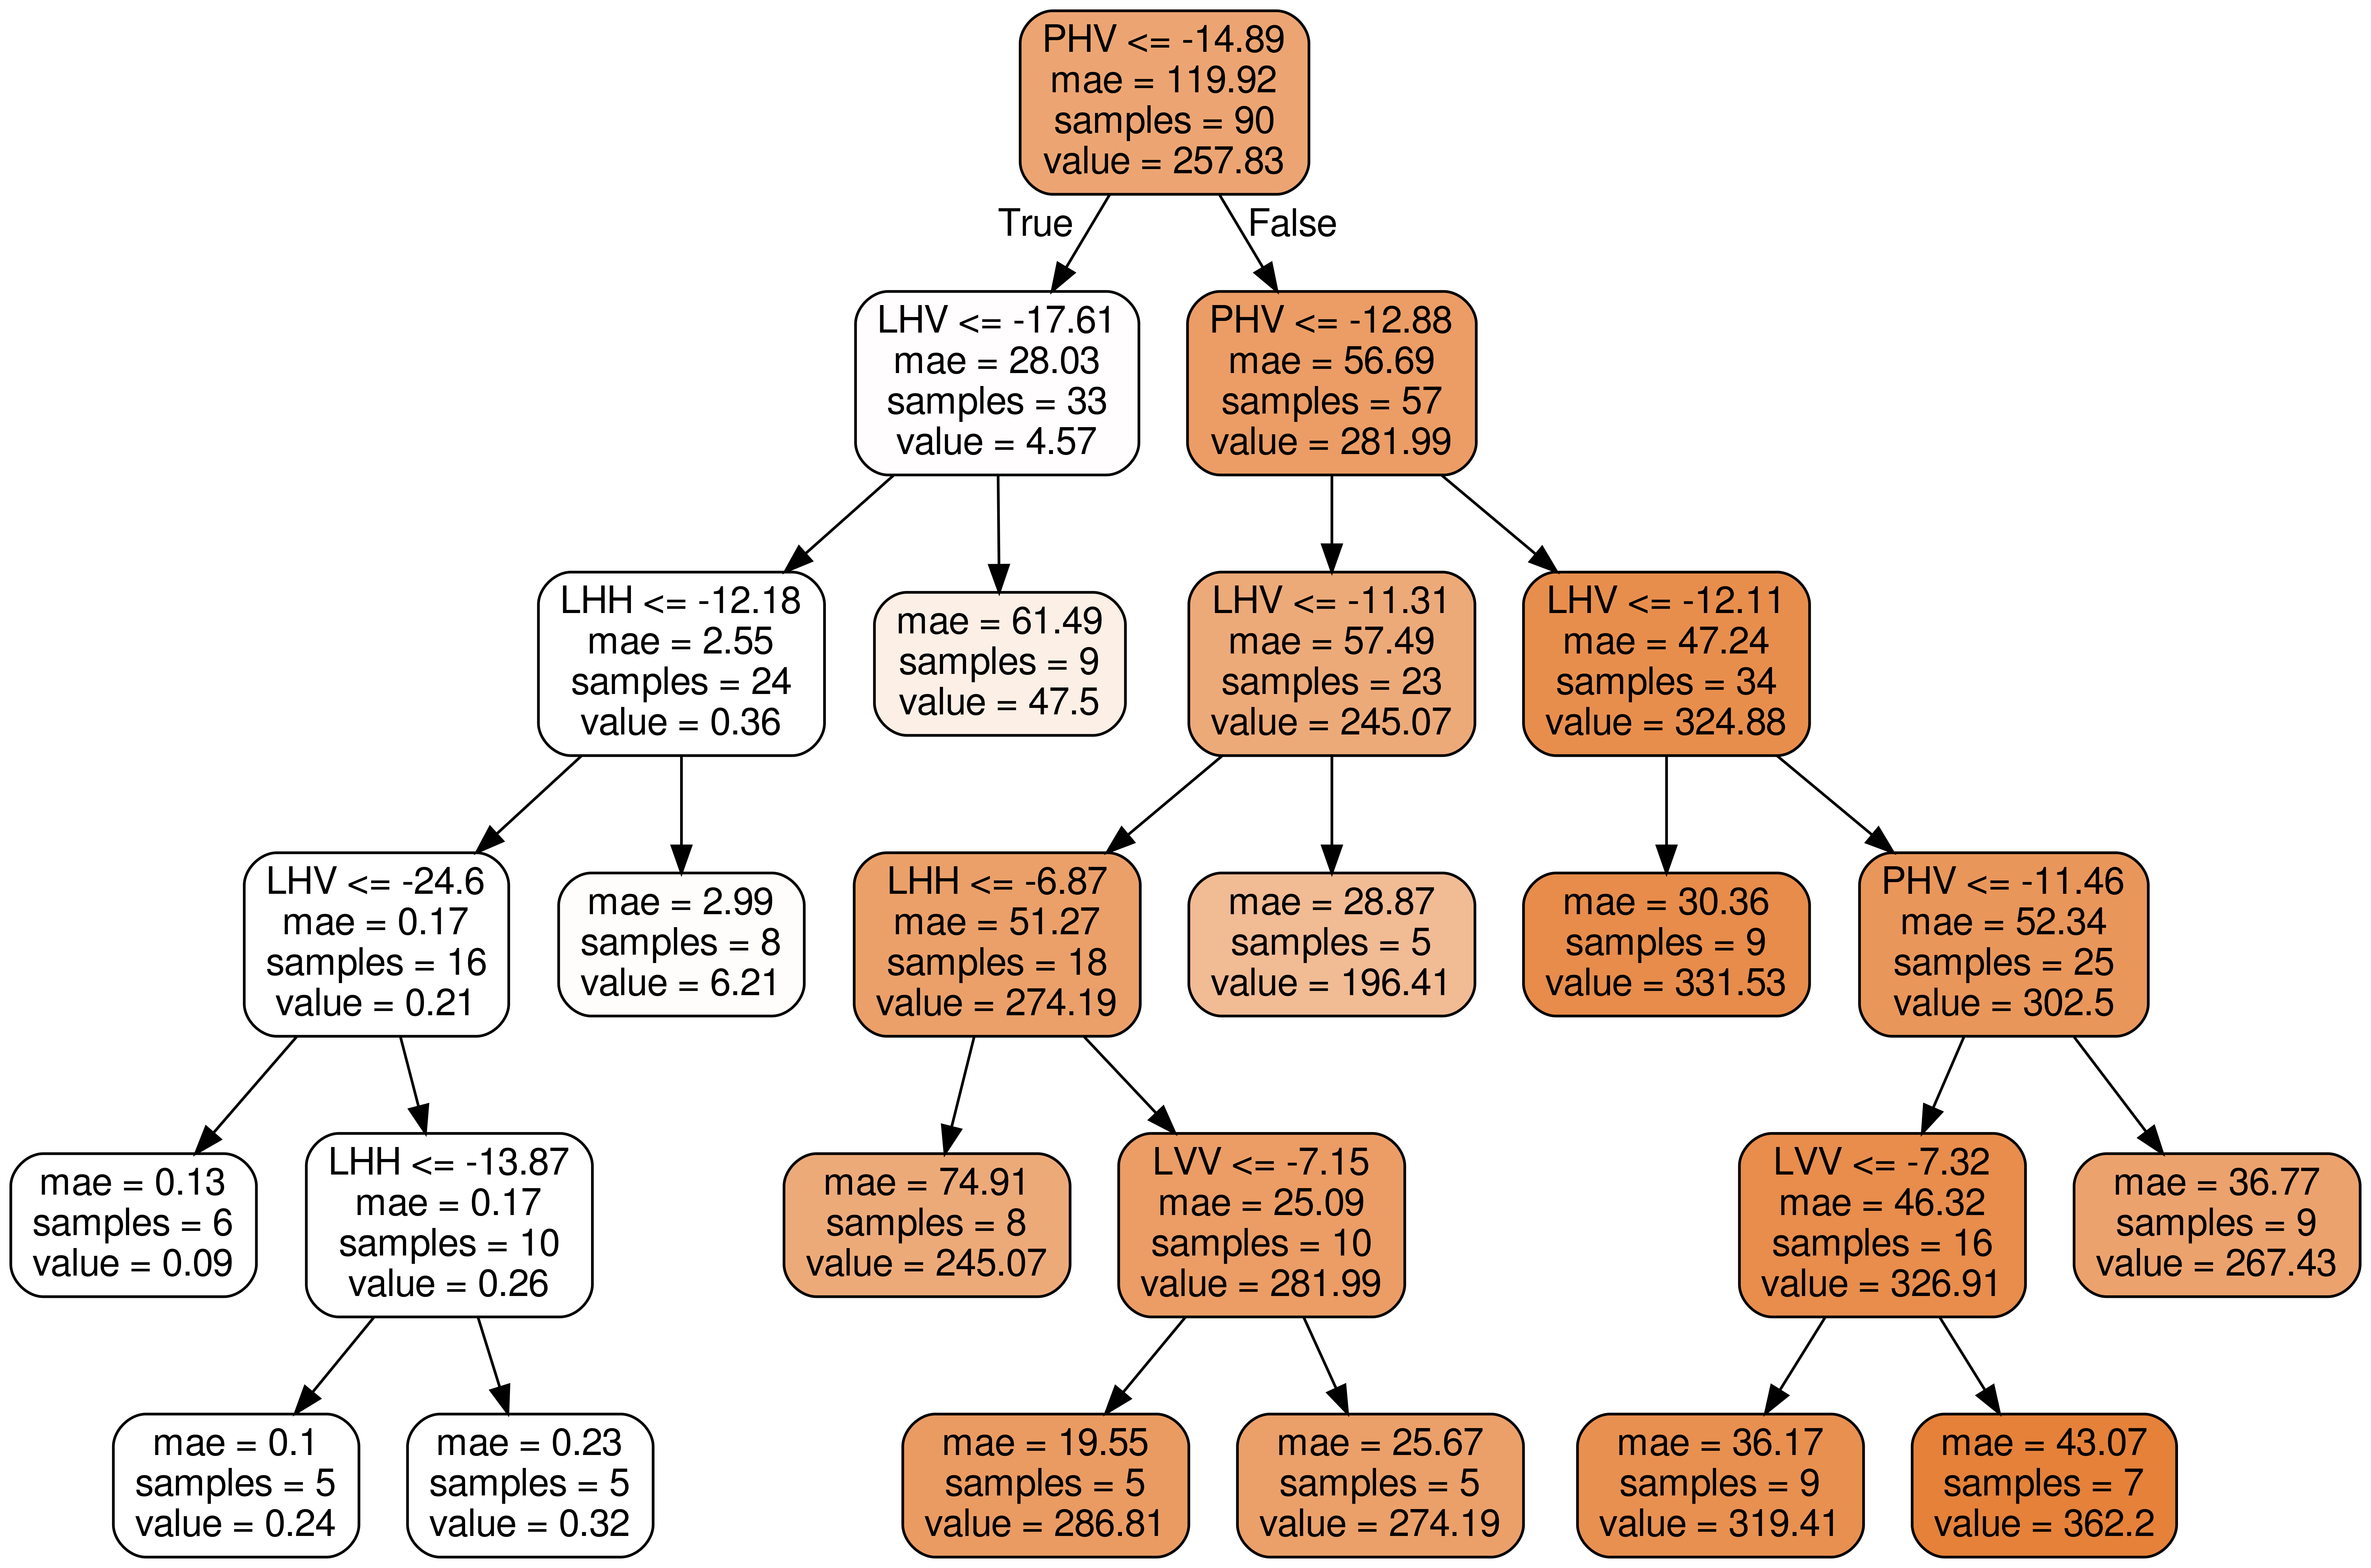

In [13]:
Image(filename = tree_image)

Feature ranking:
1. feature LVV (0.440494)
2. feature LHV (0.343376)
3. feature PHV (0.172984)
4. feature LHH (0.043146)


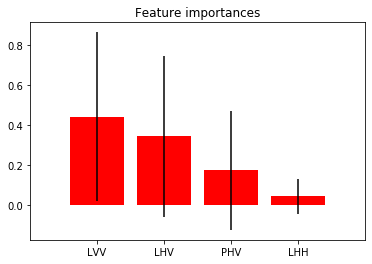

In [14]:
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

## 5. Generate and visualize the estimated agb map

The data we use for generating the estimated map has to be consistent with the training set we used for building the model.

In [15]:
LHH = plant.read_image(LHH_file).image
LHV = plant.read_image(LHV_file).image
LVV = plant.read_image(LVV_file).image
PHV = plant.read_image(PHV_file).image

opening: /home/croce/ml/dat/lband/rtc/output/LHH_colo_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/LHV_colo_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/LVV_colo_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/pband/output/warped_afrisar_dlr_T2-0_SLC_HV_geocoded_40.tiff (GDAL: GTiff) 


In [16]:
LHH_pd = pd.DataFrame(LHH)
LHV_pd = pd.DataFrame(LHV)
LVV_pd = pd.DataFrame(LVV)
PHV_pd = pd.DataFrame(PHV)

In [17]:
predict_df = pd.DataFrame({'LHH': LHH_pd.values.flatten(),
                           'LHV': LHV_pd.values.flatten(),
                           'LVV': LVV_pd.values.flatten(),
                           'PHV': PHV_pd.values.flatten(),
                          })

In [18]:
print('Target Set:')
print(predict_df.shape)
print('')
print('NaN:')
print(np.isnan(predict_df).sum())
print('')
print('Number of 0 values:')
print((training_df == 0).sum())

Target Set:
(81760, 4)

NaN:
LHH     4909
LHV     4909
LVV     4909
PHV    43915
dtype: int64

Number of 0 values:
LHH    0
LHV    0
LVV    0
PHV    0
agb    0
dtype: int64


In [19]:
warnings.filterwarnings("ignore")

predict_df['LHV'] = 10*np.log10(predict_df['LHV'])
predict_df['LHH'] = 10*np.log10(predict_df['LHH'])
predict_df['LVV'] = 10*np.log10(predict_df['LVV'])
predict_df['PHV'] = 10*np.log10(predict_df['PHV'])

to_pred = predict_df.dropna()
to_pred.describe()

LHH           LHV           LVV           PHV
count  37844.000000  37844.000000  37844.000000  37844.000000
mean      -7.903625    -13.857371     -8.223074    -16.200457
std        3.117227      4.274845      2.782262      5.853692
min      -21.001576    -30.942765    -18.954963    -40.661949
25%       -8.557328    -14.404915     -9.204778    -17.722740
50%       -6.729754    -12.045985     -7.210054    -13.928760
75%       -5.914587    -11.164834     -6.338050    -12.475173
max        5.860499      0.619370      5.569906     -0.939174

In [20]:
predictions = trained_model.predict(to_pred)

In [21]:
to_pred.insert(4, 'est_agb', predictions)
joined_df = predict_df.join(to_pred['est_agb'])

In [22]:
joined_df.describe()

LHH           LHV           LVV           PHV       est_agb
count  76848.000000  76850.000000  76848.000000  37845.000000  37844.000000
mean      -7.677877    -13.455654     -7.919625    -16.200457    200.073034
std        3.006164      3.999880      2.679672      5.853615    119.702247
min      -32.307969    -38.838865    -20.627252    -40.661949      0.081940
25%       -8.150992    -13.588360     -8.616616    -17.722723     50.630325
50%       -6.656773    -11.923823     -7.069802    -13.928770    256.976315
75%       -5.839434    -11.062832     -6.188080    -12.475181    280.672920
max        6.904562      0.619370      6.352816     -0.939174    351.568545

In [27]:
array_image = joined_df['est_agb'].values.reshape(LHH.shape)
image_obj = plant.read_image(file_LHH)
image_obj.set_image(array_image, band=0)
plant.save_image(image_obj,
                 output_file=lp_map_file,
                 force=True)

saving band 0: lopenp_14043_16015_001_160308_L090HH_CX_01_mag.slc_temp_1567060407.vrt.geo_temp_2_temp_1567060407.6670089881
## file saved: /home/croce/ml/dat/products/map_LPbands_192tr_rtc.tiff (GDAL:GTiff)


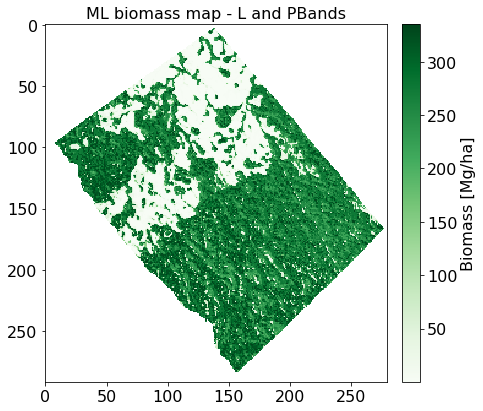

In [28]:
_ = plant.display(map_file_lp, 
                  cmap='Greens',
                  background_color='white',
                  name='ML biomass map - L and PBands',
                  colorbar_label='Biomass [Mg/ha]',
                  **options)

Share the results with the MAAP: ML model, agb ml generated map